In [2]:
import pandas as pd
from Bio import SeqIO
import matplotlib.pyplot as plt
from Bio.SeqRecord import SeqRecord
import numpy as np

In [3]:
brca2 = pd.read_csv("GSE270424_combined.raw.tsv", sep="\t")
brca1 = pd.read_excel("41586_2018_461_MOESM3_ESM.xlsx", header=2)
somatic = pd.read_csv("TCGA-BRCA.somaticmutation_wxs.tsv", sep="\t")
chr17 = str(next(SeqIO.parse("GRCh37.p13_chr17.fna", "fasta")).seq)
chr13 = str(next(SeqIO.parse("cr13.fasta", "fasta")).seq)

### Transform

In [4]:
brca1 = brca1[[
    'chromosome', 'position (hg19)', 'reference', 'alt', 'function.score.mean', 'func.class',
]]

brca1.rename(columns={
    'chromosome': 'chrom',
    'position (hg19)': 'pos',
    'reference': 'ref',
    'alt': 'alt',
    'function.score.mean': 'score',
    'func.class': 'class',
}, inplace=True)
 
brca1['class'] = brca1['class'].replace(['FUNC', 'INT'], 'FUNC/INT')

In [5]:
brca2 = brca2[['X.CHROM', 'POS', 'REF', 'ALT', 'PB']] # PB: pathogenous, benignous
brca2.rename(columns={
    'X.CHROM': 'chrom',
    'POS': 'pos',
    'REF': 'ref',
    'ALT': 'alt',
    'PB': 'class',
}, inplace=True)
brca2 = brca2[brca2['class'].notna()].reset_index(drop=True)

In [6]:
somatic = somatic[['chrom', 'start', 'ref', 'alt', 'dna_vaf']]
mask = somatic['ref'].str.len() == 1 & somatic['chrom'].isin(['chr13', 'chr17'])
somatic.rename(columns={
    'start': 'pos',
    'dna_vaf': 'score',
}, inplace=True)
somatic = somatic[mask].reset_index(drop=True)

### Procesing

In [7]:
WINDOW_SIZE = 8192
def parse_sequences(pos, ref, alt, chrn = "chr17"):
    match chrn:
        case "chr17":
            p = pos - 1 
            full_seq = chr17
        case "chr13":
            p = pos
            full_seq = chr13

    ref_seq_start = p - WINDOW_SIZE//2
    ref_seq_end = p + WINDOW_SIZE//2
    ref_seq = full_seq[ref_seq_start:ref_seq_end]
    snv_pos_in_ref = min(WINDOW_SIZE//2, p)
    var_seq = ref_seq[:snv_pos_in_ref] + alt + ref_seq[snv_pos_in_ref+1:]

    assert len(var_seq) == len(ref_seq)
    assert ref_seq[snv_pos_in_ref] == ref
    assert var_seq[snv_pos_in_ref] == alt

    return ref_seq, var_seq

In [8]:

row = brca2.sample(1).iloc[0]
ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'], "chr13")

print(row)
print('-'*50)
print(f'Reference, SNV 0: ...{ref_seq[4082:4112]}...')
print(f'Variant, SNV 0:   ...{var_seq[4082:4112]}...')


chrom       chr13
pos      32356521
ref             G
alt             A
class           B
Name: 21, dtype: object
--------------------------------------------------
Reference, SNV 0: ...CAGCCAGGCAGTCTGTATCTTGCAAAAACA...
Variant, SNV 0:   ...CAGCCAGGCAGTCTATATCTTGCAAAAACA...


In [9]:
min1, max1 = brca1['pos'].agg(['min','max']) # chr17
min2, max2 = brca2['pos'].agg(['min', 'max']) #chr13

In [10]:
offset = WINDOW_SIZE // 2
effective_chr17 = chr17[min1-1-offset:max1-1+offset]
effective_chr13 = chr13[min2-offset:max2+offset]

In [11]:
from Bio.Seq import Seq
aa13 = Seq(effective_chr13).translate(stop_symbol="")
aa17 = Seq(effective_chr17).translate(stop_symbol="")

/home/xkalibur/miniconda3/envs/DPD/lib/python3.13/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


In [12]:
# e.g.
print(aa17[:2])
print(effective_chr17[:9]) 
# CAC is Histidine (H)
# TAA es stop codon and thus is eliminated
# GUC is Valine (V)

HV
CACTAAGTC


In [13]:
hpat = pd.read_csv("aa_hydropathy.txt", sep=r"\s+")

In [14]:
hpat17 = hpat.loc[aa17, "Hydropathy"].reset_index(drop=True)
hpat13 = hpat.loc[aa13, "Hydropathy"].reset_index(drop=True)

In [15]:
len(hpat17)

27405

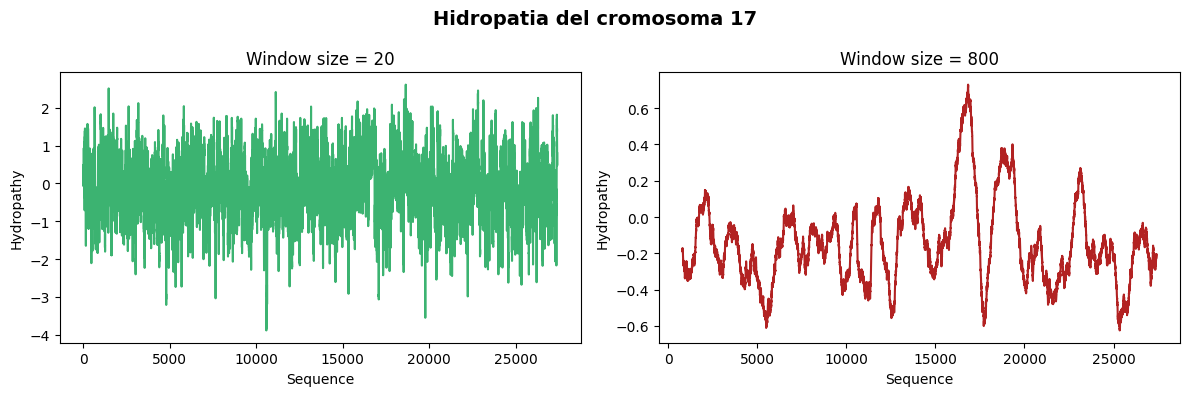

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
win_sizes = [20, 800]
colors = ['mediumseagreen', 'firebrick']

fig.suptitle("Hidropatia del cromosoma 17", fontweight='bold', fontsize=14) 

data_to_plot = {}
for ax, win_size, color in zip(axs.flatten(), win_sizes, colors):
    data_to_plot[win_size] = hpat17.rolling(window=win_size).mean()
    ax.plot(data_to_plot[win_size], color=color)
    ax.set_title(f"Window size = {win_size}")
    ax.set_xlabel("Sequence")
    ax.set_ylabel("Hydropathy")
    
plt.tight_layout()
plt.show()

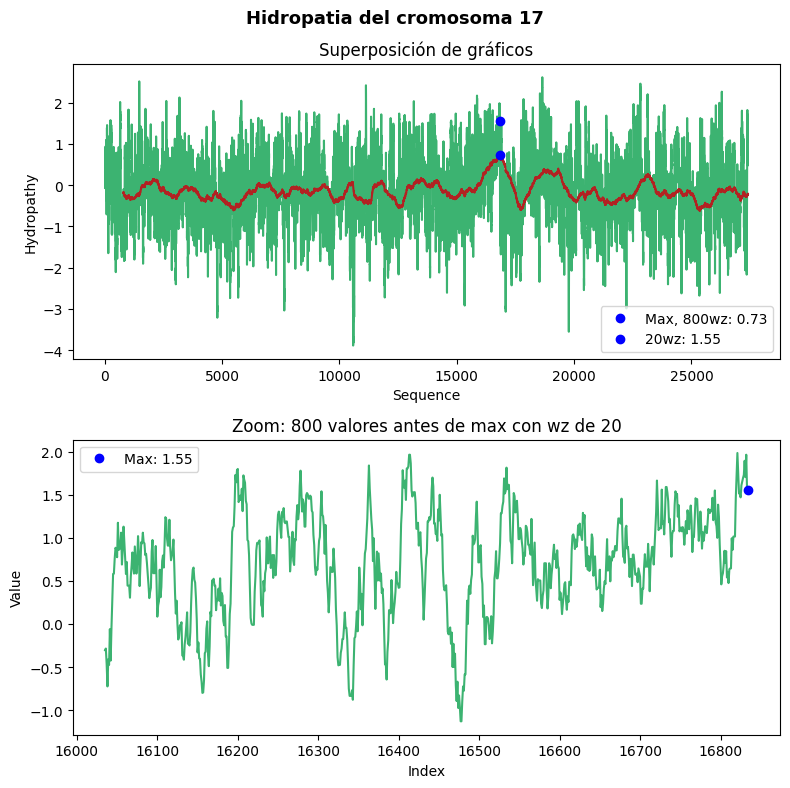

In [17]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
colors = ['mediumseagreen', 'firebrick']

fig.suptitle("Hidropatia del cromosoma 17", fontweight='bold', fontsize=13) 

axs[0].set_title('Superposición de gráficos')
axs[0].plot(data_to_plot[win_sizes[0]], color=colors[0])
axs[0].plot(data_to_plot[win_sizes[1]], color=colors[1])
axs[0].set_xlabel("Sequence")
axs[0].set_ylabel("Hydropathy")


max_idx = data_to_plot[win_sizes[1]].idxmax()
max_val800 = data_to_plot[win_sizes[1]].iloc[max_idx]
max_val20 = data_to_plot[win_sizes[0]].iloc[max_idx]
axs[0].plot(max_idx, max_val800, 'bo', label=f'Max, 800wz: {max_val800:.2f}')
axs[0].plot(max_idx, max_val20, 'bo', label=f'20wz: {max_val20:.2f}')
axs[0].legend()

start_idx = max_idx - win_sizes[1] + 1
zoomed_data = data_to_plot[win_sizes[0]].iloc[start_idx:max_idx+1]
axs[1].plot(zoomed_data, colors[0])
axs[1].set_title('Zoom: 800 valores antes de max con wz de 20')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].plot(max_idx, zoomed_data.iloc[-1], 'bo', label=f'Max: {zoomed_data.iloc[-1]:.2f}')
axs[1].legend()

    
plt.tight_layout()
plt.show()

In [18]:
aa17explore = aa17[zoomed_data.index.start:zoomed_data.index.stop]
record17explore = SeqRecord(aa17explore, id="aa17explore", description="Zoomed region of chromosome 17")
with open("aa17_explore.fasta", "w") as fasta_out:
    SeqIO.write(record17explore, fasta_out, "fasta")

Ahora, usaremos R para ver los tipos de aminoácidos

![Grafico](Rplots.png)

## Prediction

Esto debería funcionar, pero no carga el modelo

In [ ]:
"""
from evo2.models import Evo2
model = Evo2('evo2_40b_base')

# Build mappings of unique reference sequences
ref_seqs = []
ref_seq_to_index = {}

# Parse sequences and store indexes
ref_seq_indexes = []
var_seqs = []

for _, row in brca1.iterrows():
    ref_seq, var_seq = parse_sequences(row['pos'], row['ref'], row['alt'], "chrn17")

    # Get or create index for reference sequence
    if ref_seq not in ref_seq_to_index:
        ref_seq_to_index[ref_seq] = len(ref_seqs)
        ref_seqs.append(ref_seq)
    
    ref_seq_indexes.append(ref_seq_to_index[ref_seq])
    var_seqs.append(var_seq)

ref_seq_indexes = np.array(ref_seq_indexes)

print(f'Scoring likelihoods of {len(ref_seqs)} reference sequences with Evo 2...')
ref_scores = model.score_sequences(ref_seqs)

print(f'Scoring likelihoods of {len(var_seqs)} variant sequences with Evo 2...')
var_scores = model.score_sequences(var_seqs)


# subtract score of corresponding reference sequences from scores of variant sequences
delta_scores = np.array(var_scores) - np.array(ref_scores)[ref_seq_indexes]

# add delta scores to dataframe
brca1[f'evo2_delta_score'] = delta_scores

import seaborn as sns
plt.figure(figsize=(4, 2))

# Plot stripplot of distributions
p = sns.stripplot(
    data=brca1,
    x='evo2_delta_score',
    y='class',
    hue='class',
    order=['FUNC/INT', 'LOF'],
    palette=['#777777', 'C3'],
    size=2,
    jitter=0.3,
)

# Mark medians from each distribution
sns.boxplot(showmeans=True,
            meanline=True,
            meanprops={'visible': False},
            medianprops={'color': 'k', 'ls': '-', 'lw': 2},
            whiskerprops={'visible': False},
            zorder=10,
            x="evo2_delta_score",
            y="class",
            data=brca1,
            showfliers=False,
            showbox=False,
            showcaps=False,
            ax=p)
plt.xlabel('Delta likelihood score, Evo 2')
plt.ylabel('BRCA1 SNV class')
plt.tight_layout()
plt.show()


# Calculate AUROC of zero-shot predictions
from sklearn.metrics import roc_auc_score
y_true = (brca1['class'] == 'LOF')
auroc = roc_auc_score(y_true, -brca1['evo2_delta_score'])

print(f'Zero-shot prediction AUROC: {auroc:.2}')

"""